# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange/*/*/*/*/*.mxml.gz")

# Temp filter
logs_path = [x for x in logs_path if "_2" not in x and "_5" not in x and "Size1" in x and "Atomic" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  13


,0
0,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove.mxml.gz
1,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval.mxml.gz
2,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalToSequence\output\ConditionalToSequence.mxml.gz
3,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Frequency\output\Frequency.mxml.gz
4,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Loop\output\Loop.mxml.gz
5,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelMove\output\ParallelMove.mxml.gz
6,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelRemoval\output\ParallelRemoval.mxml.gz
7,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelToSequence\output\ParallelToSequence.mxml.gz
8,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialMove\output\SerialMove.mxml.gz
9,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialRemoval\output\SerialRemoval.mxml.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[5]
print(log_path)
print(log_path.split("\\")[-5] + "/" + log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path, gzip=True)

# This is a specifc step for this event log that remove an activity that shows where the drift happens
event_log = event_log[event_log['WorkflowModelElement'] != 'DRIFT_PO']

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('CaseId')))
print("Total activities: ", len(event_log.groupby('Activity')))
event_log.head(30)

Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelMove\output\ParallelMove.mxml.gz
Size1/ParallelMove
Total events:  68891
Total cases:  2999
Total activities:  25


,original_index,CaseId,Data,WorkflowModelElement,EventType,timestamp,Activity,Event_order_id
0,0,1,1970-01-01T10:33:47.462+10:00,b,complete,1970-01-01T10:33:47.462+10:00,b,0
1,1,1,1970-01-01T11:28:08.980+10:00,h,complete,1970-01-01T11:28:08.980+10:00,h,1
2,2,1,1970-01-01T11:32:51.926+10:00,g,complete,1970-01-01T11:32:51.926+10:00,g,2
3,3,1,1970-01-01T11:39:34.303+10:00,f,complete,1970-01-01T11:39:34.303+10:00,f,3
4,4,1,1970-01-01T12:32:42.811+10:00,i,complete,1970-01-01T12:32:42.811+10:00,i,4
5,5,1,1970-01-01T13:29:14.845+10:00,j,complete,1970-01-01T13:29:14.845+10:00,j,5
6,6,1,94,k,complete,1970-01-01T14:25:40.585+10:00,k,6
7,7,1,1970-01-01T15:26:04.500+10:00,j,complete,1970-01-01T15:26:04.500+10:00,j,7
8,8,1,17,k,complete,1970-01-01T16:12:34.754+10:00,k,8
9,9,1,1970-01-01T17:06:33.953+10:00,l,complete,1970-01-01T17:06:33.953+10:00,l,9


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='CaseId', activity_key='Activity', timestamp_key='timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(30)

71890


,case_id,activity_from,timestamp_from,event_order_from,activity_to,timestamp_to,event_order_to,case_order,transition_id
0,1,START,1970-01-01T10:33:47.462+10:00,0,b,1970-01-01T10:33:47.462+10:00,0.0000,0,0
1,1,b,1970-01-01T10:33:47.462+10:00,0,h,1970-01-01T11:28:08.980+10:00,1.0000,1,1
2,1,h,1970-01-01T11:28:08.980+10:00,1,g,1970-01-01T11:32:51.926+10:00,2.0000,2,2
3,1,g,1970-01-01T11:32:51.926+10:00,2,f,1970-01-01T11:39:34.303+10:00,3.0000,3,3
4,1,f,1970-01-01T11:39:34.303+10:00,3,i,1970-01-01T12:32:42.811+10:00,4.0000,4,4
5,1,i,1970-01-01T12:32:42.811+10:00,4,j,1970-01-01T13:29:14.845+10:00,5.0000,5,5
6,1,j,1970-01-01T13:29:14.845+10:00,5,k,1970-01-01T14:25:40.585+10:00,6.0000,6,6
7,1,k,1970-01-01T14:25:40.585+10:00,6,j,1970-01-01T15:26:04.500+10:00,7.0000,7,7
8,1,j,1970-01-01T15:26:04.500+10:00,7,k,1970-01-01T16:12:34.754+10:00,8.0000,8,8
9,1,k,1970-01-01T16:12:34.754+10:00,8,l,1970-01-01T17:06:33.953+10:00,9.0000,9,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 2000, continuous = True)
# TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 1, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 8000},
 1: {'start': 2000, 'end': 10000},
 2: {'start': 4000, 'end': 12000},
 3: {'start': 6000, 'end': 14000},
 4: {'start': 8000, 'end': 16000},
 5: {'start': 10000, 'end': 18000},
 6: {'start': 12000, 'end': 20000},
 7: {'start': 14000, 'end': 22000},
 8: {'start': 16000, 'end': 24000},
 9: {'start': 18000, 'end': 26000},
 10: {'start': 20000, 'end': 28000},
 11: {'start': 22000, 'end': 30000},
 12: {'start': 24000, 'end': 32000},
 13: {'start': 26000, 'end': 34000},
 14: {'start': 28000, 'end': 36000}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.005
                                    , control_flow_features={'frequency', 'probability'} #, 'causality', 'parallel', 'choice'
                                    , time_features={} 
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation() #.head(15)

frequency  percentual  probability
activity_from activity_to                                    
START         a                 1492      0.0208       0.4975
              b                 1507      0.0210       0.5025
a             c                  503      0.0070       0.3371
              d                  504      0.0070       0.3378
              e                  485      0.0067       0.3251
b             f                  501      0.0070       0.3324
              g                  487      0.0068       0.3232
              h                  519      0.0072       0.3444
c             d                  486      0.0068       0.3257
              e                  496      0.0069       0.3324
              i                  510      0.0071       0.3418
d             c                  498      0.0069       0.3338
              e                  511      0.0071       0.3425
              i                  483      0.0067       0.3237
e             c                  491      0.0068       0.3291
              d                  502      0.0070       0.3365
              i                  499      0.0069       0.3345
f             g                  496      0.0069       0.3291
              h                  492      0.0068       0.3265
              i                  519      0.0072       0.3444
g             f                  504      0.0070       0.3344
              h                  496      0.0069       0.3291
              i                  507      0.0071       0.3364
h             f                  502      0.0070       0.3331
              g                  524      0.0073       0.3477
              i                  481      0.0067       0.3192
i             j                 2999      0.0417       1.0000
j             k                 5146      0.0716       1.0000
k             j                 2147      0.0299       0.4172
              l                  975      0.0136       0.1895
              m                  968      0.0135       0.1881
              s                 1056      0.0147       0.2052
l             m                  980      0.0136       0.3268
              r                  396      0.0055       0.1320
              s                 1011      0.0141       0.3371
              t                  612      0.0085       0.2041
m             l                 1040      0.0145       0.3468
              r                  421      0.0059       0.1404
              s                  932      0.0130       0.3108
              t                  606      0.0084       0.2021
n             o                 1997      0.0278       0.6659
              p                  472      0.0066       0.1574
              u                  530      0.0074       0.1767
o             n                  472      0.0066       0.1574
              p                 2527      0.0352       0.8426
p             n                  530      0.0074       0.1767
              u                 2469      0.0343       0.8233
r             s                 1980      0.0275       1.0000
s             l                  984      0.0137       0.1976
              m                 1051      0.0146       0.2111
              r                 1163      0.0162       0.2336
              t                 1781      0.0248       0.3577
t             n                 1997      0.0278       0.6659
              o                 1002      0.0139       0.3341
u             v                 2491      0.0347       0.4935
              w                 2557      0.0356       0.5065
v             u                  995      0.0138       0.3994
              y                 1496      0.0208       0.6006
w             x                 2557      0.0356       1.0000
x             u                 1054      0.0147       0.4122
              y                 1503      0.0209       0.5878
y             z                 2999      0.0417       1.0000
z             END               2999      0.0417       1.00

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(30)

,start,end,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,8000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,10000,0.0000,232.0000,1.0841,0.0145,11.5122,0.6998,0.0000
2,4000,12000,0.0000,398.0000,1.4403,0.0249,17.1814,0.3972,0.0114
3,6000,14000,0.0000,456.0000,1.5881,0.0286,21.2618,0.1544,0.0256
4,8000,16000,0.0000,592.0000,1.9127,0.0371,29.4698,0.0215,0.0378
5,10000,18000,0.0000,651.0000,2.3225,0.0410,52.6543,0.0000,0.0564
6,12000,20000,0.0000,633.0000,1.7442,0.0397,26.3050,0.7042,0.0000
7,14000,22000,0.0000,716.0000,1.9986,0.0450,31.9746,0.3309,0.0157
8,16000,24000,0.0000,722.0000,1.7131,0.0457,37.7971,0.0001,0.0555
9,18000,26000,0.0000,1402.0000,4.1117,0.0878,311.0268,0.0000,0.1900


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[11, 23, 32]"
1,time_series_strategy,cpd_prob_freq_delta,"[11, 22, 32]"
2,time_series_strategy,cramersv_frequency,"[11, 23, 32]"
3,threshold_strategy,cramersv_frequency,"[8, 26, 32]"
4,threshold_strategy,gtest_frequency,"[8, 32]"


In [9]:
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]

In [10]:
# Grounding truth
log_size = event_log['CaseId'].nunique()
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()
print(ground_truth_events_indexes)

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

[23937, 47898]
ground_truth:  [8, 20, 32]


In [11]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[11, 23, 32]","[8, 20, 32]",1.0000,3.0000
1,time_series_strategy,cpd_prob_freq_delta,"[11, 22, 32]","[8, 20, 32]",1.0000,2.5000
2,time_series_strategy,cramersv_frequency,"[11, 23, 32]","[8, 20, 32]",1.0000,3.0000
3,threshold_strategy,cramersv_frequency,"[8, 26, 32]","[8, 20, 32]",1.0000,3.0000
4,threshold_strategy,gtest_frequency,"[8, 32]","[8, 20, 32]",0.6700,0.0000


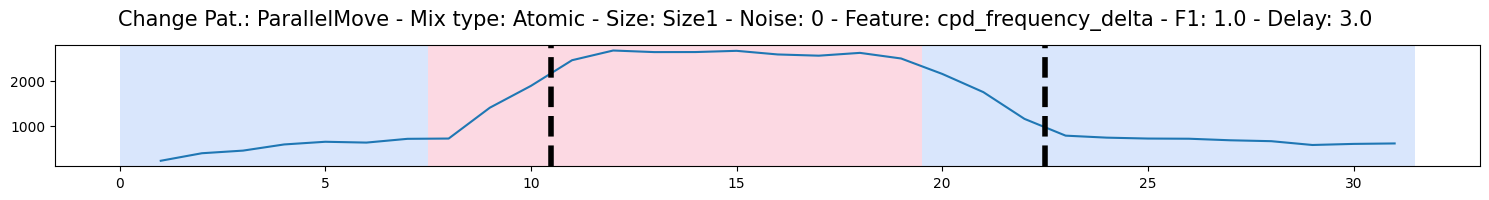

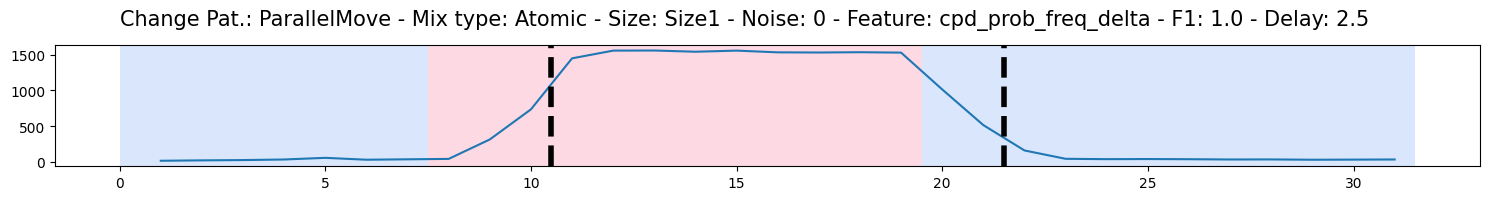

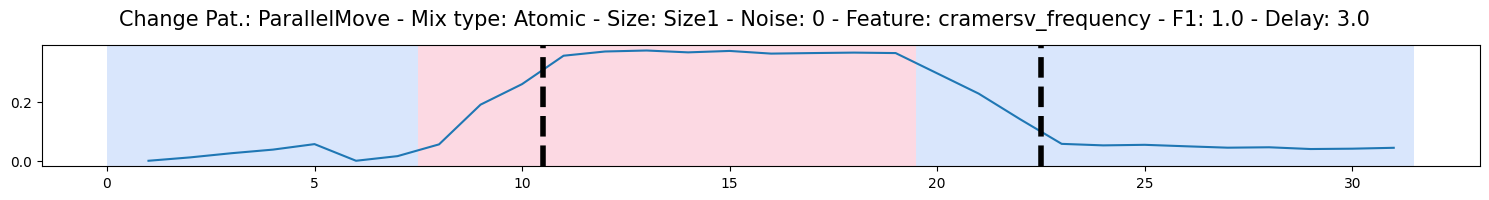

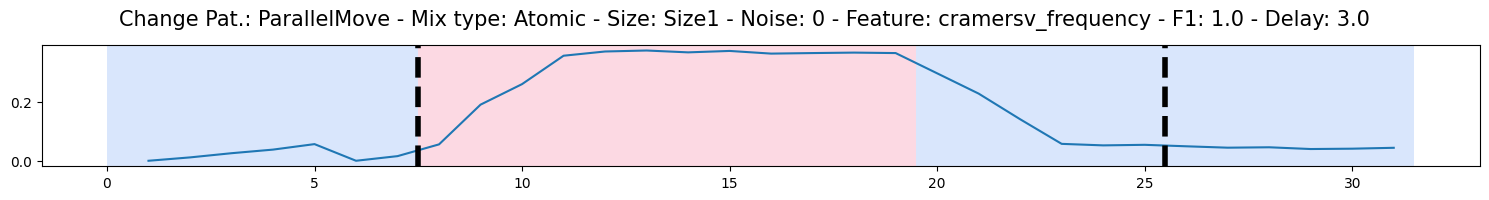

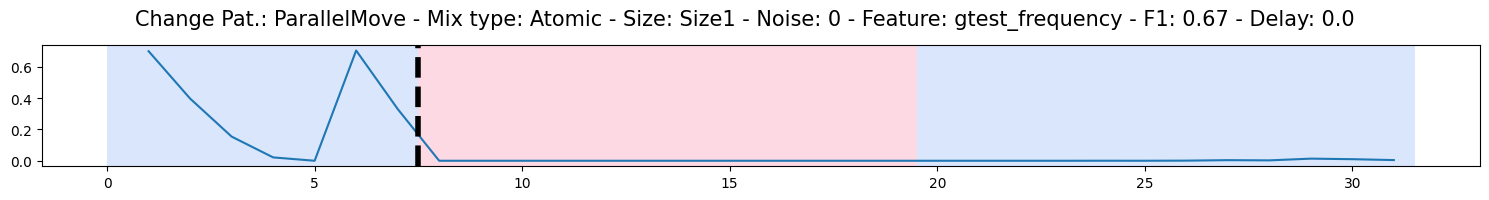

In [12]:
# Display Detection Task Results 
Noise = log_path.split("\\")[-1].split(".")[0].split("_")[-1] if log_path.split("\\")[-1].split(".")[0].split("_")[-1].isdigit() else 0

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + str(log_path.split("\\")[-3])   
                 + " - Mix type: " + str(log_path.split("\\")[-4])  
                 + " - Size: " + str(log_path.split("\\")[-5]) 
                 + " - Noise: " + str(Noise)
                 + " - Feature: " + str(result.detection_feature) 
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

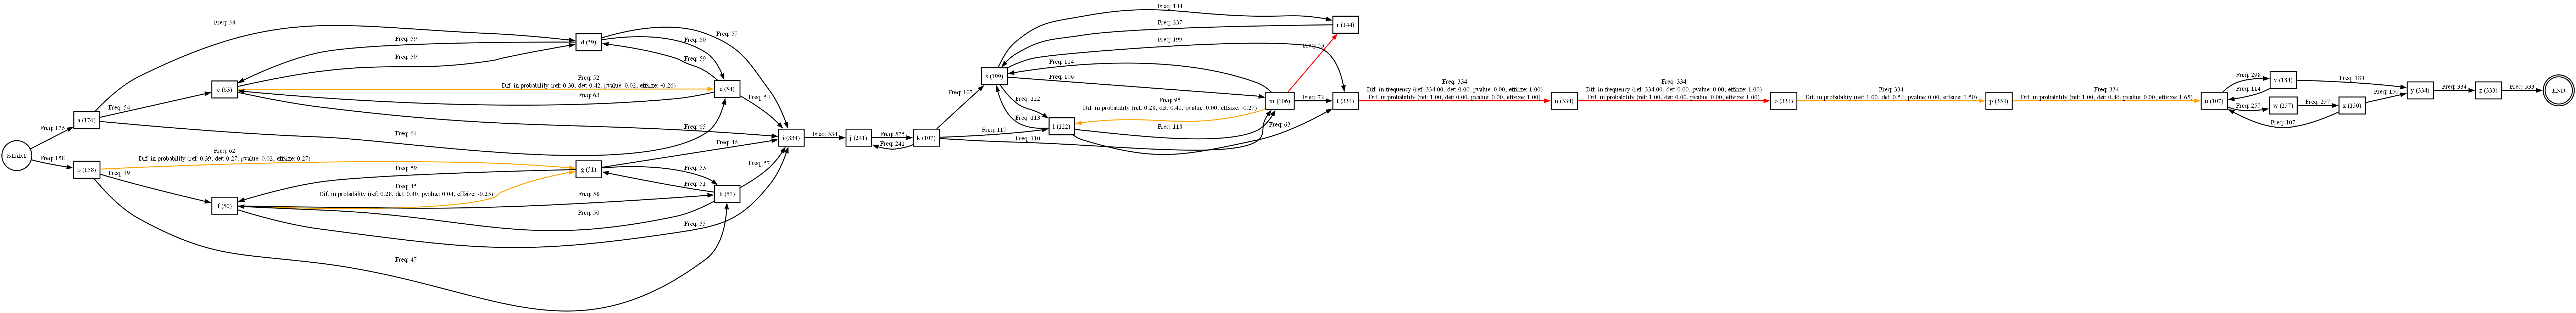

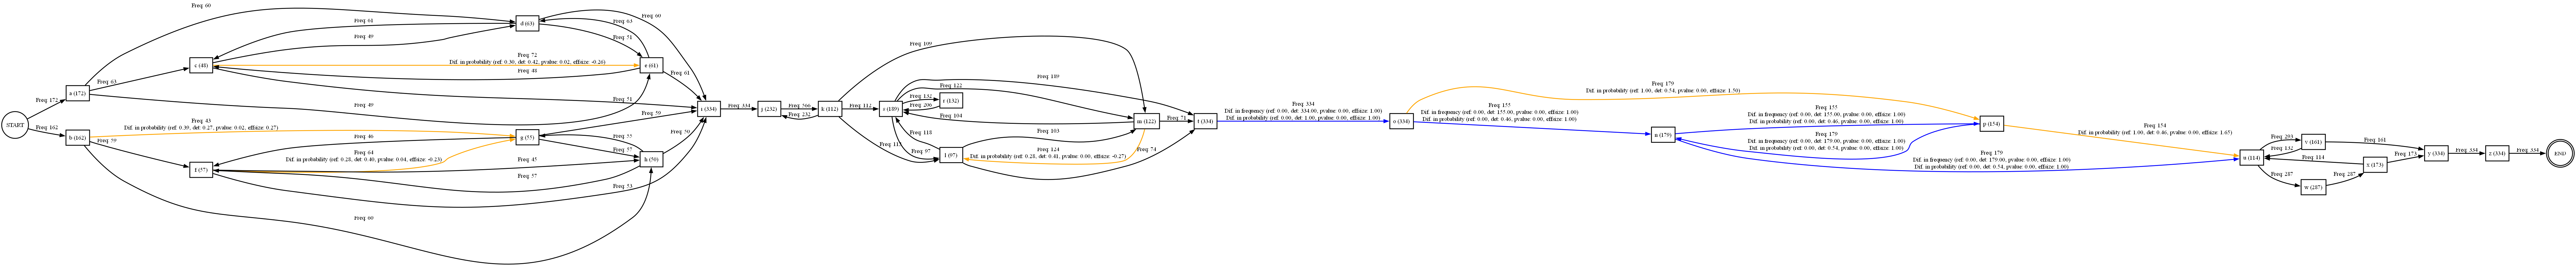

In [13]:
# Setting Localization Task
reference_window_index=0 
detection_window_index=14

TMPD_instance.set_localization_task(reference_window_index=reference_window_index, detection_window_index=detection_window_index, pvalue_threshold=0.05, effect_threshold=0.2, presence_percentage_threshold=0.01, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
significant_transition_changes, high_level_changes, reference_bpmn_text, detection_bpmn_text = TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=False)

In [14]:
significant_transition_changes

,transition,feature,perspective,transition_status,activity_status,p_value,effect_size,ref_value,det_value,dif_value
0,"(b, g)",probability,control_flow,significant difference,no change,0.0185,0.2714,0.3924,0.2654,-0.1270
1,"(c, e)",probability,control_flow,significant difference,no change,0.0189,-0.2579,0.2955,0.4186,0.1232
2,"(f, g)",probability,control_flow,significant difference,no change,0.0441,-0.2335,0.2848,0.3951,0.1103
3,"(m, l)",probability,control_flow,significant difference,no change,0.0006,-0.2743,0.2844,0.4147,0.1303
4,"(n, o)",frequency,control_flow,deleted,no change,0.0000,1.0000,334.0000,0.0000,-334.0000
5,"(n, o)",probability,control_flow,deleted,no change,0.0000,1.0000,1.0000,0.0000,-1.0000
6,"(n, p)",frequency,control_flow,new,no change,0.0000,1.0000,0.0000,155.0000,155.0000
7,"(n, p)",probability,control_flow,new,no change,0.0000,1.0000,0.0000,0.4641,0.4641
8,"(n, u)",frequency,control_flow,new,no change,0.0000,1.0000,0.0000,179.0000,179.0000
9,"(n, u)",probability,control_flow,new,no change,0.0000,1.0000,0.0000,0.5359,0.5359


In [15]:
high_level_changes

{'Transitions with variations in frequency': [('n', 'o'),
  ('n', 'p'),
  ('n', 'u'),
  ('o', 'n'),
  ('p', 'n'),
  ('t', 'n'),
  ('t', 'o')],
 'Transitions with variations in probability': [('b', 'g'),
  ('c', 'e'),
  ('f', 'g'),
  ('m', 'l'),
  ('n', 'o'),
  ('n', 'p'),
  ('n', 'u'),
  ('o', 'n'),
  ('o', 'p'),
  ('p', 'n'),
  ('p', 'u'),
  ('t', 'n'),
  ('t', 'o')],
 'New transitions added to the process': [('n', 'p'),
  ('o', 'n'),
  ('t', 'o'),
  ('n', 'u'),
  ('p', 'n')],
 'Deleted transitions from the process': [('t', 'n'), ('m', 'r'), ('n', 'o')],
 'New activities added to the process': ['None'],
 'Deleted activities from the process': ['None']}

In [16]:
reference_bpmn_text, detection_bpmn_text

("Sequence( Conditional( Sequence( 'a', Parallel( 'c', 'd', 'e' ) ), Sequence( 'b', Parallel( 'h', 'f', 'g' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', Sequence( Loop( Conditional( 'l', 'm' ), tau ), 'r' ) ), 't', 'n', 'o', 'p', Loop( Conditional( 'u', 'x', 'v', 'w' ), tau ), 'y', 'z' )",
 "Sequence( Conditional( Sequence( 'a', Parallel( 'c', 'd', 'e' ) ), Sequence( 'b', Parallel( 'h', 'f', 'g' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', 'l', 'm' ), 't', 'o', Parallel( 'n', 'p' ), Loop( Conditional( 'u', 'x', 'v', 'w' ), tau ), 'y', 'z' )")

In [17]:
# Debug

## Getting the reference window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[reference_window_index]['start']:TMPD_instance.get_windowing_strategy()[reference_window_index]['end']])
reference_window_df = TMPD_instance.get_process_representation()
reference_window_df

frequency  percentual  probability
activity_from activity_to                                    
START         a                  176      0.0220       0.5269
              b                  158      0.0198       0.4731
a             c                   54      0.0067       0.3068
              d                   58      0.0073       0.3295
              e                   64      0.0080       0.3636
b             f                   49      0.0061       0.3101
              g                   62      0.0077       0.3924
              h                   47      0.0059       0.2975
c             d                   59      0.0074       0.3352
              e                   52      0.0065       0.2955
              i                   65      0.0081       0.3693
d             c                   59      0.0074       0.3352
              e                   60      0.0075       0.3409
              i                   57      0.0071       0.3239
e             c                   63      0.0079       0.3580
              d                   59      0.0074       0.3352
              i                   54      0.0067       0.3068
f             g                   45      0.0056       0.2848
              h                   58      0.0073       0.3671
              i                   55      0.0069       0.3481
g             f                   59      0.0074       0.3734
              h                   53      0.0066       0.3354
              i                   46      0.0057       0.2911
h             f                   50      0.0063       0.3165
              g                   51      0.0064       0.3228
              i                   57      0.0071       0.3608
i             j                  334      0.0418       1.0000
j             k                  575      0.0719       1.0000
k             j                  241      0.0301       0.4191
              l                  117      0.0146       0.2035
              m                  110      0.0138       0.1913
              s                  107      0.0134       0.1861
l             m                  118      0.0147       0.4014
              s                  113      0.0141       0.3844
              t                   63      0.0079       0.2143
m             l                   95      0.0119       0.2844
              r                   53      0.0066       0.1587
              s                  114      0.0143       0.3413
              t                   72      0.0090       0.2156
n             o                  334      0.0418       1.0000
o             p                  334      0.0418       1.0000
p             u                  334      0.0418       1.0000
r             s                  237      0.0296       1.0000
s             l                  122      0.0152       0.2137
              m                  106      0.0132       0.1856
              r                  144      0.0180       0.2522
              t                  199      0.0249       0.3485
t             n                  334      0.0418       1.0000
u             v                  298      0.0372       0.5369
              w                  257      0.0321       0.4631
v             u                  114      0.0143       0.3826
              y                  184      0.0230       0.6174
w             x                  257      0.0321       1.0000
x             u                  107      0.0134       0.4163
              y                  150      0.0187       0.5837
y             z                  334      0.0418       1.0000
z             END                333      0.0416       1.0000

In [18]:
## Getting the detection window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[detection_window_index]['start']:TMPD_instance.get_windowing_strategy()[detection_window_index]['end']])
detection_window_df = TMPD_instance.get_process_representation()
detection_window_df

frequency  percentual  probability
activity_from activity_to                                    
START         a                  172      0.0215       0.5150
              b                  162      0.0203       0.4850
a             c                   63      0.0079       0.3663
              d                   60      0.0075       0.3488
              e                   49      0.0061       0.2849
b             f                   59      0.0074       0.3642
              g                   43      0.0054       0.2654
              h                   60      0.0075       0.3704
c             d                   49      0.0061       0.2849
              e                   72      0.0090       0.4186
              i                   51      0.0064       0.2965
d             c                   61      0.0076       0.3547
              e                   51      0.0064       0.2965
              i                   60      0.0075       0.3488
e             c                   48      0.0060       0.2791
              d                   63      0.0079       0.3663
              i                   61      0.0076       0.3547
f             g                   64      0.0080       0.3951
              h                   45      0.0056       0.2778
              i                   53      0.0066       0.3272
g             f                   46      0.0057       0.2840
              h                   57      0.0071       0.3519
              i                   59      0.0074       0.3642
h             f                   57      0.0071       0.3519
              g                   55      0.0069       0.3395
              i                   50      0.0063       0.3086
i             j                  334      0.0418       1.0000
j             k                  566      0.0707       1.0000
k             j                  232      0.0290       0.4099
              l                  113      0.0141       0.1996
              m                  109      0.0136       0.1926
              s                  112      0.0140       0.1979
l             m                  103      0.0129       0.3492
              s                  118      0.0147       0.4000
              t                   74      0.0092       0.2508
m             l                  124      0.0155       0.4147
              s                  104      0.0130       0.3478
              t                   71      0.0089       0.2375
n             p                  155      0.0194       0.4641
              u                  179      0.0224       0.5359
o             n                  155      0.0194       0.4641
              p                  179      0.0224       0.5359
p             n                  179      0.0224       0.5375
              u                  154      0.0192       0.4625
r             s                  206      0.0257       1.0000
s             l                   97      0.0121       0.1796
              m                  122      0.0152       0.2259
              r                  132      0.0165       0.2444
              t                  189      0.0236       0.3500
t             o                  334      0.0418       1.0000
u             v                  293      0.0366       0.5052
              w                  287      0.0359       0.4948
v             u                  132      0.0165       0.4505
              y                  161      0.0201       0.5495
w             x                  287      0.0359       1.0000
x             u                  114      0.0143       0.3972
              y                  173      0.0216       0.6028
y             z                  334      0.0418       1.0000
z             END                334      0.0418       1.0000

In [19]:
### Ground Truth
change_pattern_ground_truth = log_path.split("\\")[-3]

change_activities_ground_truth = {
    'ConditionalMove': {
        'change_pattern_name': 'Conditional-Move',
        'characterization_activities': ['n', 'p'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'ConditionalRemoval': {
        'change_pattern_name': 'Conditional-Removal',
        'characterization_activities': ['re'],
        'localization_activities': ['re', 'y', 'z']
    },
    'ConditionalToSequence': {
        'change_pattern_name': 'Conditional-To-Sequence',
        'characterization_activities': ['p', 'q'],
        'localization_activities': ['p', 'q', 'u', 'o']
    },
    'Frequency': {
        'change_pattern_name': 'Frequency',
        'characterization_activities': ['p', 'q', 'u', 'o'],
        'localization_activities': ['p', 'q', 'u', 'o']
    },
    'Loop': {
        'change_pattern_name': 'Loop',
        'characterization_activities': ['k'],
        'localization_activities': ['k', 'l', 's']
    },
    'ParallelMove': {
        'change_pattern_name': 'Parallel-Move',
        'characterization_activities': ['n', 'p'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'ParallelRemoval': {
        'change_pattern_name': 'Parallel-Removal',
        'characterization_activities': ['re'],
        'localization_activities': ['y', 'z', 'z1']
    },
    'ParallelToSequence': {
        'change_pattern_name': 'Parallel-To-Sequence',
        'characterization_activities': ['n', 'o'],
        'localization_activities': ['n', 'o', 't', 'p']
    },
    'SerialMove': {
        'change_pattern_name': 'Serial-Move',
        'characterization_activities': ['n'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'SerialRemoval': {
        'change_pattern_name': 'Serial-Removal',
        'characterization_activities': ['re'],
        'localization_activities': ['re', 'y', 'z']
    },
    'Skip': {
        'change_pattern_name': 'Skip',
        'characterization_activities': ['n'],
        'localization_activities': ['n', 't', 'o']
    },
    'Substitute': {
        'change_pattern_name': 'Replace',
        'characterization_activities': ['sub', 'z1'],
        'localization_activities': ['sub', 'z1', 'z', 'y']
    },
    'Swap': {
        'change_pattern_name': 'Swap',
        'characterization_activities': ['n', 'o'],
        'localization_activities': ['n', 'o', 't', 'p', 'u']
    } 
}

localization_ground_truth = change_activities_ground_truth[change_pattern_ground_truth]['localization_activities']
localization_ground_truth

['n', 'p', 't', 'o', 'u']

In [20]:
### Validation metrics

# Getting the distinct activities in the Localization Result
localization_distinct_activities = set()
for key, value in islice(TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1].items(), 6):
    if isinstance(value, list): # Check if the value is a list
        # Skip the list if it contains only "None"
        if len(value) == 1 and value[0] == "None":
            continue
        for item in value:
            if isinstance(item, tuple): # If the items are tuples, extend the set with the tuple items
                localization_distinct_activities.update(item)
            else: # If the items are not tuples (i.e., strings), add them directly to the set
                localization_distinct_activities.add(item)
localization_result = list(localization_distinct_activities)
print(localization_result)

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(localization_ground_truth, localization_result)

localization_task_validation_results = ({
    'localization_activities_precision': precision,
    'localization_activities_recall': recall,
    'localization_activities_f1_score': f1_score
})

localization_task_validation_results

['n', 'p', 'c', 'r', 'o', 't', 'e', 'g', 'b', 'u', 'f', 'l', 'm']


{'localization_activities_precision': 0.38461538461538464,
 'localization_activities_recall': 1.0,
 'localization_activities_f1_score': 0.5555555555555556}

In [21]:
# # Skip Pattern temporary test
# TMPD_instance.detection_bpmn_text = "Sequence( Conditional( Sequence( 'b', Parallel( 'h', 'f', 'g' ) ), Sequence( 'a', Parallel( 'e', 'd', 'c' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', Sequence( Parallel( 'm', 'l' ), 'r' ) ), 't', Conditional( 'n', 'tau'), 'o', 'p', Loop( Conditional( 'x', 'v', 'w', 'u' ), tau ), 'y', 'z' )"
# TMPD_instance.detection_bpmn_text

# # Conditional Removal Pattern temporary test
# TMPD_instance.reference_bpmn_text = "Sequence( Conditional( Sequence( 'b', Parallel( 'h', 'f', 'g' ) ), Sequence( 'a', Parallel( 'c', 'd', 'e' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', Sequence( Conditional( 'm', 'l' ), 'r' ) ), 't', 'n', 'o', Conditional( 'p', 'q' ), Loop( Conditional( 'w', 'u', 'x', 'v' ), tau ), 'y', Conditional( 're', 'z') )"
# TMPD_instance.reference_bpmn_text

## Step 6b - Setting Characterization Task

In [ ]:
# Setting Characterization Task
# "gemini-2.5-flash", "gemini-2.5-pro", "gpt-4o", "gpt-4.1", "gpt-4.1-mini"
TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4.1", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_bpmn_approach.yaml') 
# TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.5-pro", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
characterization_prompt, characterization_response = TMPD_instance.get_characterization_task()

In [ ]:
print(characterization_prompt)


# Role and Goal
You are an expert process mining analyst specializing in concept drift characterization. Your objective is to deeply understand and explain the transformation observed between two versions of a business process (reference window and detection window). This includes identifying what changed, how the changes are interconnected, and what broader patterns and impacts they suggest — always grounded in the provided data sources.

# Two-Phase Analysis Approach
Your analysis must follow this structured approach:

# PHASE 1: HOLISTIC CHANGE CHARACTERIZATION
First, provide a comprehensive, multi-perspective analysis of the changes observed.

**Your analysis must go beyond simply listing differences.** The user has access to the raw data and statistical tables. Your job is to interpret this information holistically, identify key insights, and present a coherent narrative that explains the *nature*, *scope*, and *interconnectedness* of the changes.

## Input Data
    - reference_t

In [ ]:
print(characterization_response)

Here is the two-phase analysis of the process transformation.

# PHASE 1: HOLISTIC CHANGE CHARACTERIZATION

### 1. Executive Summary

The analysis reveals a significant concept drift characterized by a fundamental structural transformation within a specific segment of the process. While no activities were added or deleted, the sequential flow involving activities **t, n, o, and p** was completely redesigned. The original linear path `t → n → o → p` has been replaced by a more complex structure where activity **o** becomes a gateway to a parallel execution of activities **n** and **p**. This change is highly localized but represents a change of high magnitude, fundamentally altering the logic and flow in this part of the process. The drift is concentrated in the control-flow perspective, as no data on time, resources, or other data attributes was available for analysis.

### 2. Integrated Change Characterization

#### **Control-Flow Perspective**

The primary change observed is a major 

In [ ]:
# Getting the control-flow patterns from the LLM response
def extract_control_flow_patterns_with_llm(llm_response: str):
    """
    Uses the provided LLM model instance to extract a list of control-flow pattern names
    from the Control-Flow Change Pattern Classification section of an LLM response, restricting to canonical names.
    """

    import google.generativeai as genai
    with open('Temp/google_api_key.txt', 'r') as file:
        os.environ["GOOGLE_CLOUD_API_KEY"] = file.read().rstrip()
        genai.configure(api_key=os.environ['GOOGLE_CLOUD_API_KEY'])
    model = genai.GenerativeModel("gemini-2.5-flash")

    canonical_patterns = [
    "Serial-Removal", "Parallel-Removal", "Conditional-Removal", "Replace",
    "Serial-Move", "Parallel-Move", "Conditional-Move", "Swap",
    "Parallel-To-Sequence", "Conditional-To-Sequence", "Control-Dependency",
    "Skip", "Loop", "Frequency"
    ]

    pattern_list_str = ", ".join(f'"{p}"' for p in canonical_patterns)
    prompt = f"""
    Given the following process mining analysis response, extract ONLY the list of control-flow pattern names (as a Python list of strings) that are classified in the 'Control-Flow Change Pattern Classification' section. 
    You MUST choose the names ONLY from this list: [{pattern_list_str}]. 
    If the response uses a synonym or a different name, map it to the closest canonical name from the list above. 
    Do not include any explanation, just output the list.

    Example: ["Conditional-Move", "Parallel-Move"]

    LLM Response:
    {llm_response}
    """
    response = model.generate_content(prompt)
    result = response.text.strip()
    try:
        patterns = eval(result)
        if isinstance(patterns, list):
            return patterns
        else:
            return [result]
    except Exception:
        return [result]


llm_respose_patterns = extract_control_flow_patterns_with_llm(characterization_response)
print("LLM Response Patterns: ", llm_respose_patterns)
print("Ground Truth Patterns: ", change_activities_ground_truth[change_pattern_ground_truth]['change_pattern_name'])

try:
    precision, recall, f1_score = TMPD_utils.list_match_metrics([change_activities_ground_truth[change_pattern_ground_truth]['change_pattern_name']], llm_respose_patterns)
except:
    precision, recall, f1_score = -1, -1, -1
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

LLM Response Patterns:  ['Parallel-To-Sequence']
Ground Truth Patterns:  Parallel-Move
Precision: 0.0, Recall: 0.0, F1-Score: 0


## Step 6c - Setting Explanation Task

In [26]:
# TODO